# Latent Space Detections on Novelty MNIST

## Caution: important experiment, please do not adjust

The contents within this file are for running a publication-quality experiment and producing the associated figures and results. As such, it is finely tuned for specific high-quality graphics using the `primary.mplstyle` file. Please do not adjust. If you need to replicate results on your local system, please create a new notebook and copy contents from here.

In [1]:
import sys
sys.path.append('../..')  # Expose top level program access

import re
import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from sklearn.covariance import EllipticEnvelope
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
from pathlib import Path
from utils import tools, metrics, supported_preprocessing_transforms
from modules.aae_base_module import AAEBaseModule
from modules.vae_base_module import VAEBaseModule
from models import supported_models
from datasets import supported_datamodules
from scipy.stats import gaussian_kde
from utils.dtypes import *

logging.getLogger("matplotlib").setLevel(logging.WARNING)  # Suppress verbose font warnings from matplotlib

In [2]:
# import configurations and paths to logged models
root = Path.cwd().parents[1]
log_path = root / 'logs' / 'NoveltyMNISTDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_v*'))

# filter the models that don't provide structured latent representations
for i, p in enumerate(paths_to_archived_models.copy()):
    if not re.search('VAE|AAE', str(p)):
        paths_to_archived_models.remove(p)

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------
SimpleVAE/archive_v1_2021-04-21
SimpleAAE/archive_v3_2021-05-07


In [3]:
def load_modules(paths_to_archived_models: List[Path]) -> dict:
    # Load the checkpoints for all the training modules and save them in a dictionary
    module_catalog = {}

    for pth in paths_to_archived_models:

        model_type = pth.parent.name
        model_name = pth.name
        config = tools.load_config(pth / 'configuration.yaml', silent=True)

        # Unsupervising region proposal is called implicity in this line, see utils/preprocessing.py
        preprocessing_transforms = supported_preprocessing_transforms[config['data-parameters']['preprocessing']]

        datamodule = supported_datamodules[config['experiment-parameters']['datamodule']](
            data_transforms=preprocessing_transforms,
            **config['data-parameters'])

        if 'PCA' in model_type:

            _, pca_test_labels = datamodule.split(train=False)

            with open(pth / 'fitted_model.p', 'rb') as f:
                model = pickle.load(f)
                module = PCABaseModule(model)
        else:
            ckpt_path = next(iter((pth / 'checkpoints').glob('val_*')))

            datamodule.setup('test')

            # Handle the various model instantiations
            if 'AAE' in model_type:
                model = supported_models[model_type](
                    in_shape=datamodule.data_shape,
                    latent_nodes=config['module-parameters']['latent_nodes'])
                module = AAEBaseModule(model, **config['module-parameters'])
            elif 'VAE' in model_type:
                model = supported_models[model_type](
                    in_shape=datamodule.data_shape,
                    latent_nodes=config['module-parameters']['latent_nodes'])
                module = VAEBaseModule(model, **config['module-parameters'])
            elif 'CAE' in model_type:
                model = supported_models[model_type](in_shape=datamodule.data_shape)
                module = CAEBaseModule(model, **config['module-parameters'])
            else:
                raise ValueError(f'Model substring not found, got {model_type}')

            # Load the state_dict into the module architecture
            checkpoint = torch.load(ckpt_path)
            module.load_state_dict(checkpoint['state_dict'])

        if model_type not in module_catalog:
            module_catalog[model_type] = {}
        module_catalog[model_type][model_name] = module
        print(f'Loaded state dict for: {model_type}/{model_name}')
        
    return module_catalog, datamodule
        
module_catalog, datamodule = load_modules(paths_to_archived_models)

Loaded state dict for: SimpleVAE/archive_v1_2021-04-21
Loaded state dict for: SimpleAAE/archive_v3_2021-05-07


In [4]:
# Collect scores and labels on test set for all models and save to a dictionary
result_catalog = {}

for model_type, model_variants in module_catalog.items():
    start_time = time.time()
    
    for model_name, module in model_variants.items():
        
        latent_vecs = []
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        print(f'------\n{short_name}\n------')
        
        if short_name not in result_catalog:
            result_catalog[short_name] = {
                'latent_vecs': [],
                'scores':      [], 
                'labels':      []
            }
        
        # Set the model/components to evaluation mode
        if 'AAE' in model_type:
            module.encoder.eval()
            module.decoder.eval()
        else:
            module.model.eval()

        with torch.no_grad():
            for batch_nb, batch in enumerate(datamodule.test_dataloader()):

                result = module.test_step(batch, batch_nb)
                
                # Populate results
                latent_vecs.extend(result['images']['batch_lt'].cpu().numpy())
                test_novelty_scores.extend(result['scores'])
                test_novelty_labels.extend(result['labels'].cpu().numpy())
                print(f'[BATCH {batch_nb}] Mean score: {np.mean(result["scores"])}')
                    
        result_catalog[short_name]['latent_vecs'] = latent_vecs
        result_catalog[short_name]['scores'] = test_novelty_scores
        result_catalog[short_name]['labels'] = test_novelty_labels
        print(f'{short_name} Time: {time.time() - start_time:.2f} s\n')

------
SimpleVAE-v1
------
[BATCH 0] Mean score: 0.34578871726989746
[BATCH 1] Mean score: 0.35029399394989014
[BATCH 2] Mean score: 0.3452569544315338
[BATCH 3] Mean score: 0.349689245223999
[BATCH 4] Mean score: 0.34916162490844727
[BATCH 5] Mean score: 0.34214651584625244
[BATCH 6] Mean score: 0.3495454788208008
[BATCH 7] Mean score: 0.3483823537826538
[BATCH 8] Mean score: 0.3479686677455902
[BATCH 9] Mean score: 0.34432852268218994
SimpleVAE-v1 Time: 3.18 s

------
SimpleAAE-v3
------
[BATCH 0] Mean score: 0.5745812058448792
[BATCH 1] Mean score: 0.579025387763977
[BATCH 2] Mean score: 0.5741379857063293
[BATCH 3] Mean score: 0.576151430606842
[BATCH 4] Mean score: 0.5782550573348999
[BATCH 5] Mean score: 0.5794404149055481
[BATCH 6] Mean score: 0.5775456428527832
[BATCH 7] Mean score: 0.5788815021514893
[BATCH 8] Mean score: 0.5770773887634277
[BATCH 9] Mean score: 0.5749516487121582
SimpleAAE-v3 Time: 1.08 s



In [5]:
# Prepare latent representations for advanced plotting
aae_sn = 'SimpleAAE-v3'
aae_results = result_catalog[aae_sn]
aae_lt = np.stack(aae_results['latent_vecs'], axis=0)

vae_sn = 'SimpleVAE-v1'
vae_results = result_catalog[vae_sn]
vae_lt = np.stack(vae_results['latent_vecs'], axis=0)

labels = result_catalog[aae_sn]['labels']

2021-07-30 17:36:21,587 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-07-30 17:36:22,785 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:22,786 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:22,786 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:22,787 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:22,787 - DEBUG - STREAM b'IDAT' 149 76
2021-07-30 17:36:22,789 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:22,790 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:22,790 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:22,791 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:22,791 - DEBUG - STREAM b'IDAT' 149 74
2021-07-30 17:36:22,793 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:22,793 - DEBUG - STREAM b'PLTE' 41 39
2021-07-30 17:36:22,794 - DEBUG - STREAM b'tRNS' 92 12
2021-07-30 17:36:22,794 - DEBUG - STREAM b'pHYs' 116 9
2021-07-30 17:36:22,795 - DEBUG - STREAM b'IDAT' 137 43
2021-07-30 17:36:22,797 - DEBUG - STREAM b'IHDR' 16 13
2021-07

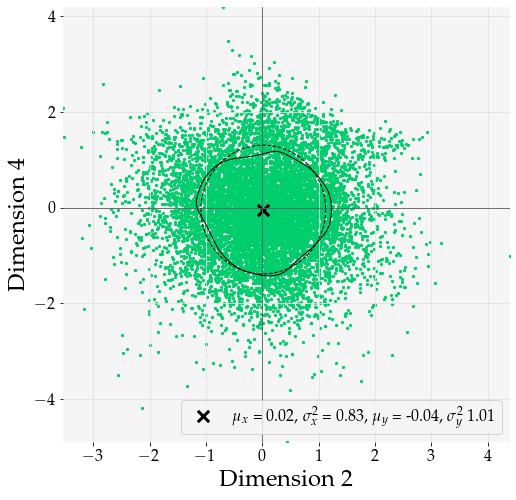

2021-07-30 17:36:23,430 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:23,430 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:23,430 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:23,431 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:23,431 - DEBUG - STREAM b'IDAT' 149 181
2021-07-30 17:36:23,443 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:23,443 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:23,444 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:23,444 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:23,445 - DEBUG - STREAM b'IDAT' 149 118
2021-07-30 17:36:23,447 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:23,447 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:23,447 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:23,448 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:23,448 - DEBUG - STREAM b'IDAT' 149 181
2021-07-30 17:36:23,450 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:23,450 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:23,451 - DEBUG - STREAM b'tRNS' 101 15


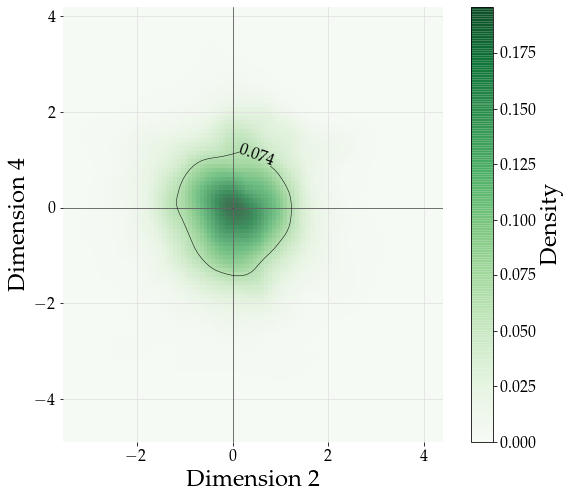

2021-07-30 17:36:25,719 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:25,720 - DEBUG - STREAM b'PLTE' 41 42
2021-07-30 17:36:25,720 - DEBUG - STREAM b'tRNS' 95 13
2021-07-30 17:36:25,721 - DEBUG - STREAM b'pHYs' 120 9
2021-07-30 17:36:25,721 - DEBUG - STREAM b'IDAT' 141 61
2021-07-30 17:36:25,806 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:25,806 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:25,806 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:25,807 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:25,807 - DEBUG - STREAM b'IDAT' 149 823


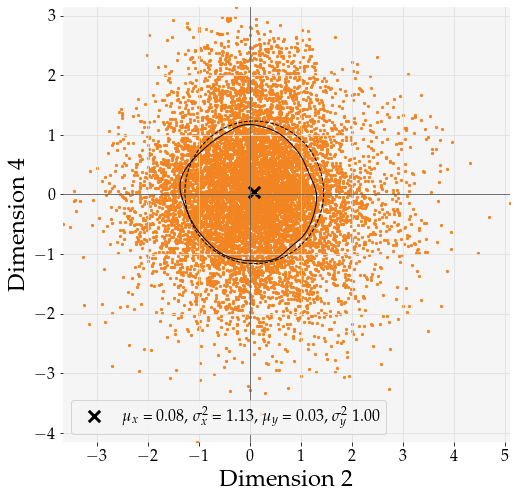

2021-07-30 17:36:26,381 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:26,381 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:26,382 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:26,382 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:26,383 - DEBUG - STREAM b'IDAT' 149 184
2021-07-30 17:36:26,394 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:26,395 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:26,395 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:26,395 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:26,396 - DEBUG - STREAM b'IDAT' 149 111
2021-07-30 17:36:26,398 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:26,398 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:26,398 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:26,399 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:26,399 - DEBUG - STREAM b'IDAT' 149 137
2021-07-30 17:36:26,401 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:26,402 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:26,402 - DEBUG - STREAM b'tRNS' 101 15


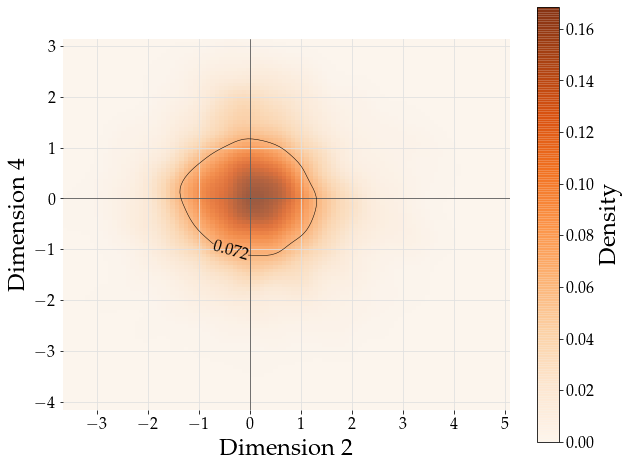

In [6]:
def gaussian2d(x, y, x_mu, x_var, y_mu, y_var):
    arg_x = (x - x_mu)**2 / (2*x_var**2)
    arg_y = (y - y_mu)**2 / (2*y_var**2)    
    return np.exp(-(arg_x + arg_y))

def fwhm(std):
    return 2*np.sqrt(2*np.log(2))*std

# Use standard custom styling
plt.style.use('../../utils/_extras/primary.mplstyle')

def latent_vis_2d(latent_vecs, dim_x: int = 2, dim_y: int = 4, save_name=None, color='C1'):

    # Code for setting up advanced plotting and graphing
    x_mean, x_var = latent_vecs[:, dim_x].mean(), latent_vecs[:, dim_x].var()
    y_mean, y_var = latent_vecs[:, dim_y].mean(), latent_vecs[:, dim_y].var()
    kde = gaussian_kde(latent_vecs[:, [dim_x, dim_y]].T)

    x_steps = np.linspace(latent_vecs[:, dim_x].min(), latent_vecs[:, dim_x].max(), 100)
    y_steps = np.linspace(latent_vecs[:, dim_y].min(), latent_vecs[:, dim_y].max(), 100)
    X, Y = np.meshgrid(x_steps, y_steps)
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))



    Zgaussian = gaussian2d(X, Y, x_mean, x_var, y_mean, y_var)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(latent_vecs[:, dim_x], latent_vecs[:, dim_y], s=5, alpha=1., color=color)

    ax.contour(
        X, Y, Zgaussian, levels=[fwhm(Zgaussian.std())], 
        colors='k', linewidths=1., linestyles='--', alpha=1.0)
    ax.contour(
        X, Y, Z.reshape(X.shape), levels=[fwhm(Z.std())], 
        colors='k', linewidths=1., linestyles='-', alpha=1.0)

    ax.scatter([x_mean], [y_mean], color='k', marker='x', s=2**7, 
                label=r'$\mu_x$ = {:.2f}, $\sigma^2_x$ = {:.2f}, $\mu_y$ = {:.2f}, $\sigma^2_y$ {:.2f}'.format(x_mean, x_var, y_mean, y_var))

    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.legend()
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')

    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'LatentScatter-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    cb = ax.imshow(Z.reshape(X.shape), cmap='Oranges' if color=='C6' else 'Greens', 
              extent=[x_steps[0], x_steps[-1], y_steps[0], y_steps[-1]], origin='lower', alpha=0.75)
    c = ax.contour(X, Y, Z.reshape(X.shape), colors='k', levels=[fwhm(Z.std())], linewidths=0.5)

    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')
    ax.clabel(c, fontsize=16)
    
    cb = fig.colorbar(cb)
    cb.set_label('Density')
    
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'LatentKDE-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()
    
latent_vis_2d(aae_lt, save_name=aae_sn, color='C1')
latent_vis_2d(vae_lt, save_name=vae_sn, color='C6')

Next, we assess envelope detection performance for all dimesnions of the latent space, and also when detecting on 2 dimensions only (for visualization purposes)

2021-07-30 17:36:28,720 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:28,721 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:28,721 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:28,722 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:28,722 - DEBUG - STREAM b'IDAT' 149 200
2021-07-30 17:36:28,728 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:28,728 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:28,728 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:28,729 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:28,729 - DEBUG - STREAM b'IDAT' 149 268


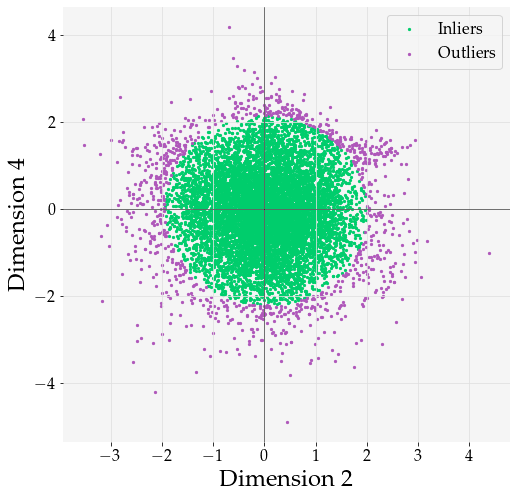

2021-07-30 17:36:29,126 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:29,127 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:29,127 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:29,127 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:29,128 - DEBUG - STREAM b'IDAT' 149 96
2021-07-30 17:36:29,130 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:29,130 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:29,130 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:29,131 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:29,131 - DEBUG - STREAM b'IDAT' 149 98
2021-07-30 17:36:29,133 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:29,134 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:29,134 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:29,134 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:29,135 - DEBUG - STREAM b'IDAT' 149 129
2021-07-30 17:36:29,137 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:29,137 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:29,138 - DEBUG - STREAM b'tRNS' 101 15
20

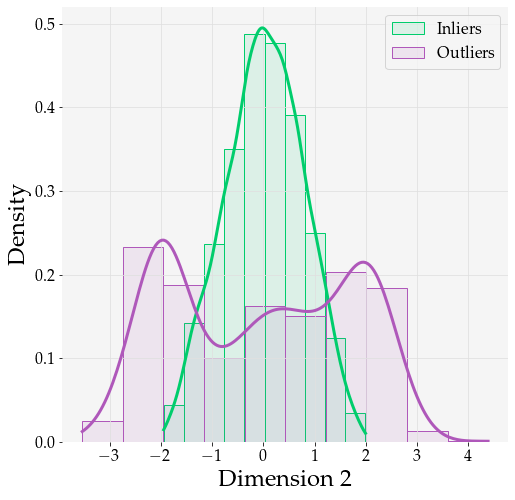

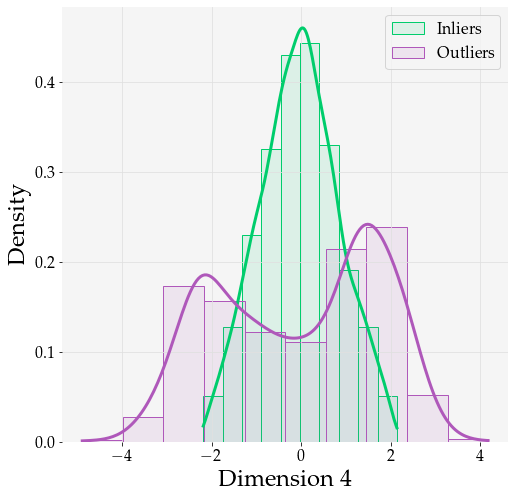

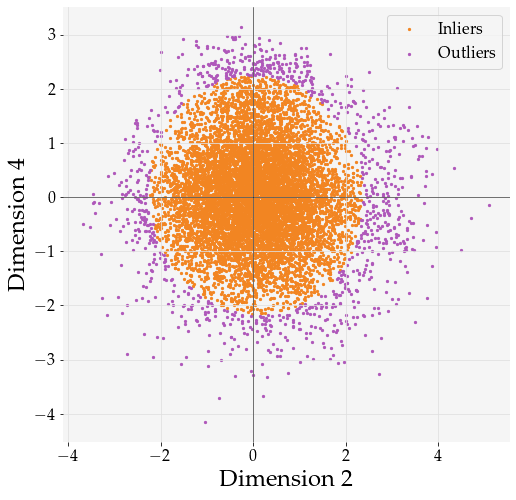

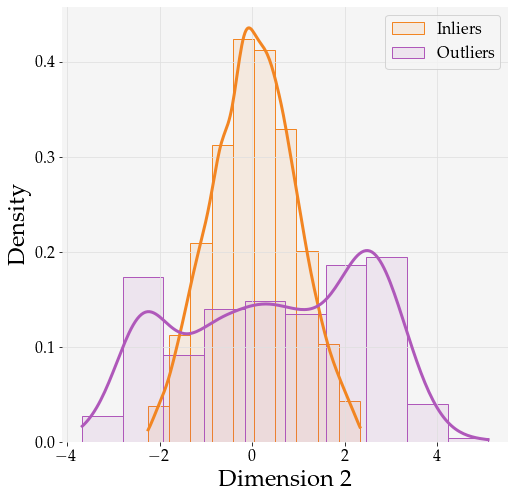

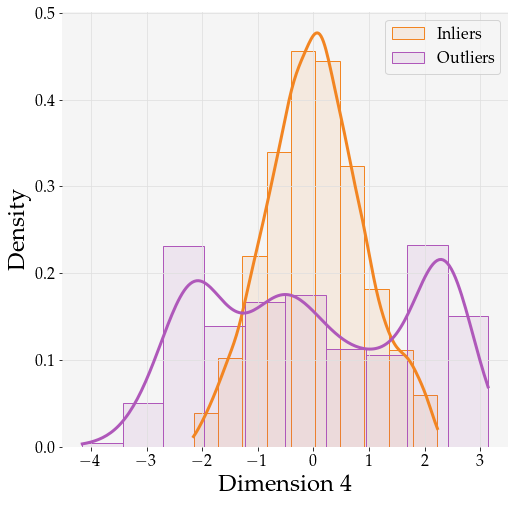

In [7]:
def latent_vis_envelope_2d(latent_vecs, dim_x: int = 2, dim_y: int = 4, save_name=None, stat='density', color='C1'):

    dim_x = 2
    dim_y = 4
    cov_2d = EllipticEnvelope(random_state=49).fit(latent_vecs[:, [dim_x, dim_y]])
    pred_2d = cov_2d.predict(latent_vecs[:, [dim_x, dim_y]])

    inliers_2d = ((pred_2d + 1) // 2).astype(bool)
    outliers_2d = ~inliers_2d
    
    # Plot the 2d results
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(latent_vecs[inliers_2d, dim_x], latent_vecs[inliers_2d, dim_y], s=5, label='Inliers', color=color)
#     ax.scatter(latent_vecs[np.array(labels).astype(bool), dim_x], latent_vecs[np.array(labels).astype(bool), dim_y],
#                s=5, label='Novelties', color='C5')  # This line is for seeing the distr. of novelties
    ax.scatter(latent_vecs[outliers_2d, dim_x], latent_vecs[outliers_2d, dim_y], s=5, label='Outliers', color='C3')

    
    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'2dOutliers-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    # Plot x dimension
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=latent_vecs[inliers_2d, dim_x], bins=10, alpha=0.1, stat=stat, 
                 kde=True, color=color, edgecolor=color, label='Inliers')
    sns.histplot(data=latent_vecs[outliers_2d, dim_x], bins=10, alpha=0.1, stat=stat,
                 kde=True, color='C3', edgecolor='C3', label='Outliers')
    
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'InlierOutlierDensityX-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    # Plot y dimension
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=latent_vecs[inliers_2d, dim_y], bins=10, alpha=0.1, stat=stat,
                 kde=True, color=color, edgecolor=color, label='Inliers')
    sns.histplot(data=latent_vecs[outliers_2d, dim_y], bins=10, alpha=0.1, stat=stat, 
                 kde=True, color='C3', edgecolor='C3', label='Outliers')
    ax.set_xlabel(f'Dimension {dim_y}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'InlierOutlierDensityY-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()
    
    # Here, the negative mahalanobis distance is used as the novelty score
    return -cov_2d.mahalanobis(latent_vecs[:, [dim_x, dim_y]])

aae_scores_2d = latent_vis_envelope_2d(aae_lt, save_name=aae_sn, color='C1')
vae_scores_2d = latent_vis_envelope_2d(vae_lt, save_name=vae_sn, color='C6')

2021-07-30 17:36:46,482 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:46,483 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:46,483 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:46,483 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:46,484 - DEBUG - STREAM b'IDAT' 149 109
2021-07-30 17:36:46,498 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:46,498 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:46,498 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:46,499 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:46,499 - DEBUG - STREAM b'IDAT' 149 518
2021-07-30 17:36:46,510 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:46,510 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:46,511 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:46,511 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:46,511 - DEBUG - STREAM b'IDAT' 149 137
2021-07-30 17:36:46,525 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:46,526 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:46,526 - DEBUG - STREAM b'tRNS' 101 15


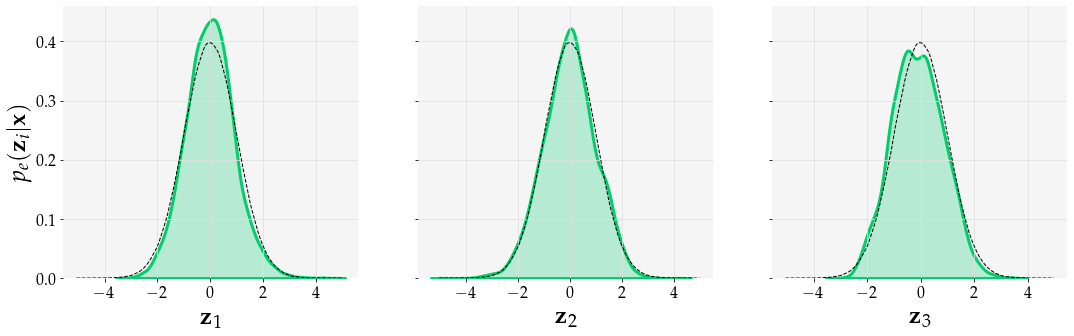

2021-07-30 17:36:59,452 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:59,452 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:59,453 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:59,453 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:59,453 - DEBUG - STREAM b'IDAT' 149 144
2021-07-30 17:36:59,456 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:59,456 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:59,457 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:59,457 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:59,457 - DEBUG - STREAM b'IDAT' 149 136
2021-07-30 17:36:59,460 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:59,461 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:59,461 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:59,462 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:59,462 - DEBUG - STREAM b'IDAT' 149 123
2021-07-30 17:36:59,464 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:59,465 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:59,465 - DEBUG - STREAM b'tRNS' 101 15


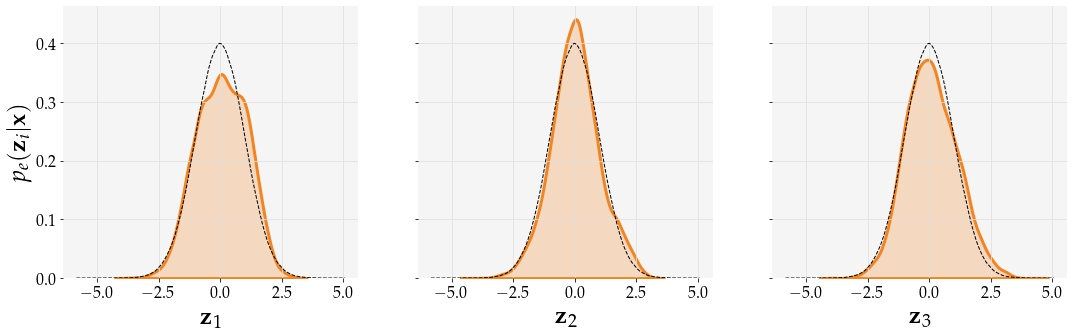

In [8]:
def latent_vis_envelope_nd(latent_vecs, dim_x: int = 2, dim_y: int = 4, save_name=None, color='C1'):

    cov = EllipticEnvelope(random_state=49).fit(latent_vecs)

    pred = cov.predict(latent_vecs)
    standard_normal = np.random.normal(0., 1., 1000000)

    inliers = ((pred + 1) // 2).astype(bool)
    outliers = ~inliers

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))
    sns.kdeplot(ax=ax[0], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[0], data=latent_vecs[:, 3], fill=True, lw=3, color=color)
    ax[0].set_ylabel('$p_{e}(\\mathbf{z}_i|\\mathbf{x})$')
    ax[0].set_xlabel('$\\mathbf{z}_1$')
    
    sns.kdeplot(ax=ax[1], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[1], data=latent_vecs[:, 4], fill=True, lw=3, color=color)
    ax[1].set_xlabel('$\\mathbf{z}_2$')
    
    sns.kdeplot(ax=ax[2], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[2], data=latent_vecs[:, 5], fill=True, lw=3, color=color)
    ax[2].set_xlabel('$\\mathbf{z}_3$')
    plt.show()
    
    # Here, the negative mahalanobis distance is used as the novelty score
    return -cov.mahalanobis(latent_vecs)
    
aae_scores_nd = latent_vis_envelope_nd(aae_lt, color='C1')
vae_scores_nd = latent_vis_envelope_nd(vae_lt, color='C6')

2021-07-30 17:36:59,620 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-07-30 17:36:59,835 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:59,835 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:59,835 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:59,836 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:59,836 - DEBUG - STREAM b'IDAT' 149 127
2021-07-30 17:36:59,838 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:59,838 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:59,839 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:59,839 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:59,839 - DEBUG - STREAM b'IDAT' 149 128
2021-07-30 17:36:59,843 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:36:59,843 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:36:59,844 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:36:59,844 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:36:59,844 - DEBUG - STREAM b'IDAT' 149 97
2021-07-30 17:36:59,849 - DEBUG - STREAM b'IHDR' 16 13
2021

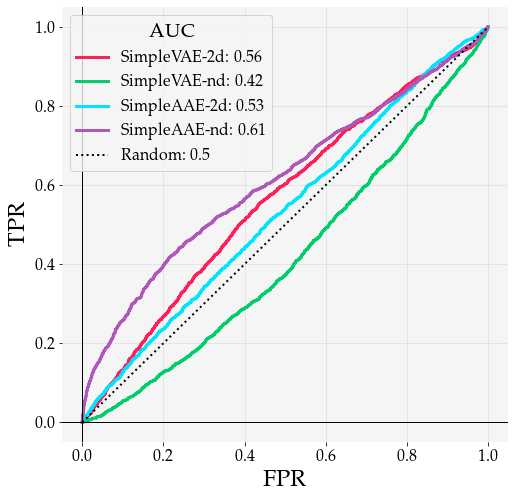

In [9]:
# Use the negative Mahalanobis distance as the novelty score
latent_scores_catalog = {
    f'{aae_sn}-2d': aae_scores_2d,
    f'{aae_sn}-nd': aae_scores_nd,
    f'{vae_sn}-2d': vae_scores_2d,
    f'{vae_sn}-nd': vae_scores_nd,
}

fig, ax = plt.subplots(figsize=(8, 8))

for sn in result_catalog:
    for suf in ['2d', 'nd']:
        scores = latent_scores_catalog[f'{sn}-{suf}']
        fpr, tpr, thresholds, auc = metrics.roc(scores, result_catalog[sn]['labels'])

        ax.plot(fpr, tpr, label=f'{sn.split("-")[0]}-{suf}: {auc:.2f}')
    

ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random: 0.5')
ax.legend(title='AUC')#, bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.axhline(0, 0, c='k', lw=1)
ax.axvline(0, 0, c='k', lw=1)

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

plt.savefig('ROC-latentspace_NoveltyMNIST.pdf', format='pdf', bbox_inches='tight')
plt.show()

2021-07-30 17:37:00,333 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:00,334 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:00,334 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:37:00,334 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:37:00,335 - DEBUG - STREAM b'IDAT' 149 372
2021-07-30 17:37:00,338 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:00,338 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:00,338 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:37:00,339 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:37:00,339 - DEBUG - STREAM b'IDAT' 149 129
2021-07-30 17:37:00,341 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:00,342 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:00,342 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:37:00,342 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:37:00,343 - DEBUG - STREAM b'IDAT' 149 114
2021-07-30 17:37:00,346 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:00,346 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:00,347 - DEBUG - STREAM b'tRNS' 101 15


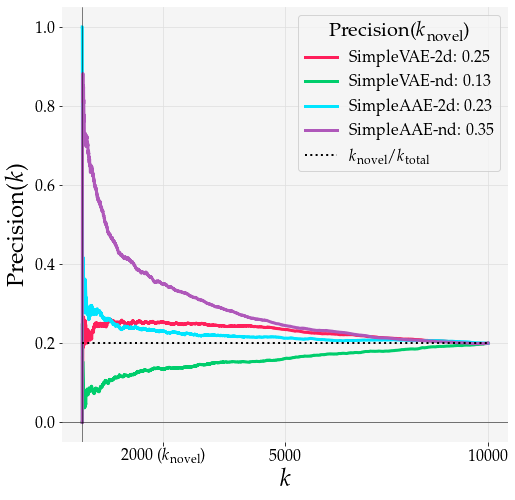

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

for sn in result_catalog:
    for suf in ['2d', 'nd']:
        scores = latent_scores_catalog[f'{sn}-{suf}']


        pak = metrics.precision_at_k(scores, result_catalog[sn]['labels'])

        uniques, counts = np.unique(result_catalog[sn]['labels'], return_counts=True)
        random = counts.min() / counts.sum()

        ax.plot(pak, label=f'{sn.split("-")[0]}-{suf}: {pak[int(sum(result_catalog[sn]["labels"]))]:.2f}')
    
ax.plot([0, len(pak)], [random, random], 'k:', lw=2, label='$k_{\mathrm{novel}}/k_{\mathrm{total}}$')

ax.set_xlabel('$k$')
ax.set_ylabel('Precision($k$)')
ax.legend(title='Precision($k_{\mathrm{novel}}$)')#, bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.set_xticks([counts[1], int(counts.sum()/2), counts.sum()])
ax.set_xticklabels([str(counts[1])+' ($k_{\mathrm{novel}}$)', int(counts.sum()/2), counts.sum()])

# Draw axes for styling
ax.axhline(0, 0, c='k', lw=0.5)
ax.axvline(0, 0, c='k', lw=0.5)

plt.savefig('Pak-latentspace_NoveltyMNIST.pdf', format='pdf', bbox_inches='tight')
plt.show()

# --------------------------------------------------------------------
# Extra plots

(10000, 10)


[]

2021-07-30 17:37:00,937 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:00,937 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:00,938 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:37:00,938 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:37:00,938 - DEBUG - STREAM b'IDAT' 149 67
2021-07-30 17:37:00,944 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:00,945 - DEBUG - STREAM b'PLTE' 41 36
2021-07-30 17:37:00,945 - DEBUG - STREAM b'tRNS' 89 11
2021-07-30 17:37:00,945 - DEBUG - STREAM b'pHYs' 112 9
2021-07-30 17:37:00,946 - DEBUG - STREAM b'IDAT' 133 33
2021-07-30 17:37:00,948 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:00,948 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:00,948 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:37:00,949 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:37:00,949 - DEBUG - STREAM b'IDAT' 149 60
2021-07-30 17:37:00,951 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:00,951 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:00,951 - DEBUG - STREAM b'tRNS' 101 15
2021

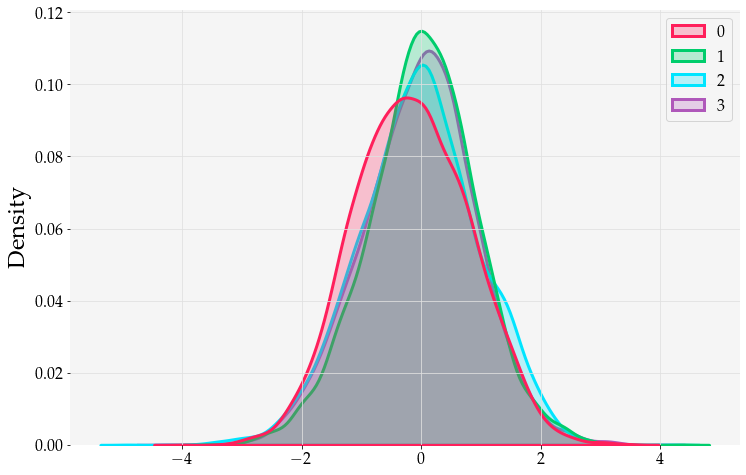

In [11]:
import seaborn as sns
import pandas as pd

print(vae_lt.shape)

# Plotting the probability density function of each latent dim
data = pd.DataFrame(aae_lt)

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(data=pd.DataFrame(aae_lt[:, ::2]), lw=3, fill=True)
ax.plot()

NameError: name 'X' is not defined

2021-07-30 17:37:01,181 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:01,182 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:01,182 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:37:01,182 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:37:01,183 - DEBUG - STREAM b'IDAT' 149 170
2021-07-30 17:37:01,186 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:01,186 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:01,187 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:37:01,187 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:37:01,187 - DEBUG - STREAM b'IDAT' 149 139
2021-07-30 17:37:01,191 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:01,191 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:01,192 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 17:37:01,192 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 17:37:01,192 - DEBUG - STREAM b'IDAT' 149 174
2021-07-30 17:37:01,195 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 17:37:01,196 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 17:37:01,196 - DEBUG - STREAM b'tRNS' 101 15


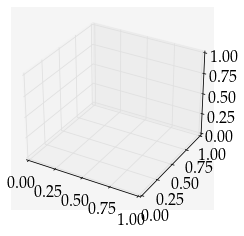

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, Z.reshape(X.shape), cmap='YlOrRd')
plt.show()